# Demo para analizar y estudiar los datos disponibles de TIPOS de ANIMALES


In [1]:
#@title Librerías a usar
import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn import tree
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
  
import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("Librerías cargadas")

Librerías cargadas


In [2]:
#@title Funciones Auxiliares

# variables auxiliares 
atributo_clase = ""

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# devuelve listas de columnas numéricas y no numéricas
def devolNombreColumnas(ndf):
  colValues = []
  colNoValues = []
  for col in ndf.columns:
    if ndf[col].dtypes in ("object", "bool"):
      colNoValues.append( col )
    else:
      colValues.append( col )
  return colValues, colNoValues

# función auxiliar para separar datos de entrada y de salida
def separarDatosXY(ndf, atributo_clase="", xSoloNros=True):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # saca el atributo clase (OPCIONAL)
  if atributo_clase == "":
    Y = []
  else:
    # datos atributo clase
    Y = np.array( cdf.pop(atributo_clase).fillna("-NAN-") )
  if xSoloNros:
    # se queda sólo con los atributos numéricos (OPCIONAL)
    for col in cdf.columns:
      if cdf[col].dtypes == "object":
          cdf.pop( col )
  # datos de entrada
  X = np.array(cdf.fillna(0.001))
  return X, Y, np.array(cdf.columns)

def convColsNumericas(ndf, atributos_no_convertir = []):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # convierte todas las no numéricas a numéricas (OPCIONAL)
  for col in cdf.columns:
    if col not in atributos_no_convertir:
      if cdf[col].dtypes == "object":
        # genera diccionario de valores
        valores = cdf[col].unique()
        diccValores = dict(zip(valores, range(len(valores))))
        # realiza el reemplazo
        cdf[col] = cdf[col].map(lambda s: diccValores.get(s) if s in diccValores else s)
  return cdf
  
# función auxiliar
def generar_estadisticas_detalladas(orDF, titulo=""):
  # título
  print("\n", titulo, ": ") 
  # obtiene las estadísticas generales
  estDF = orDF.describe().transpose()
  #  genera y formatea las estadísticas
  if "min" in estDF and "max" in estDF:
    rangoValores = "[ " + estDF["min"].apply('{:.2f}'.format) + " ; " + estDF["max"].apply('{:.2f}'.format) + " ]"    
  else:
    rangoValores = estDF["unique"].fillna(0.0).apply('{:.0f}'.format)
  rangoValores.name = "Rango Valores"
  # para campos no numéricos muestra las cantidades por valor
  for col in orDF.columns:
    if orDF[col].dtypes in ("object", "bool"):
      auxStr = str( orDF[col].value_counts() ).replace("\n", " ; ")
      if (auxStr.index("Name")-3) > 0:
        # saca lo del final porque no sirve
        auxStr = auxStr[:auxStr.index("Name")-3]
      rangoValores[col] = "{ " + auxStr + " }"
  if "mean" in estDF and "std" in estDF:      
    promValores = estDF["mean"].fillna(0.0).apply('{:.3f}'.format) + " ± " + estDF["std"].fillna(0.0).apply('{:.3f}'.format)
  else:
    promValores = estDF["count"].apply('{:.0f}'.format)
  promValores.name = "Promedio ± Desvío"
  # obtiene valores "ceros" y nulos
  zero_val = (orDF == 0.00).astype(int).sum(axis=0)
  zero_val.name = "¿Valores Ceros?"
  mis_val = orDF.isnull().sum()
  mis_val.name = "¿Valores Nulos?"
  # prepara la nueva tabla para mostrar
  nTable = pd.concat([orDF.dtypes, rangoValores, promValores, zero_val, mis_val], axis=1)
  nTable = nTable.rename( columns = {0: 'Tipo Valor',  1: 'Rango Valores', 2: 'Promedio ± Desvío', 3: '¿Valores Ceros?', 4: '¿Valores Nulos?' } )
  # muestra la nueva tabla
  pd.set_option('max_colwidth', None)
  display(nTable.fillna("-"))
  print("Tiene " + str(orDF.shape[1]) + " atributos y " + str(orDF.shape[0]) + " ejemplos.")
  print("\n")
  return 

print("Funciones auxiliares definidas.")

Funciones auxiliares definidas.


# Carga de los Datos:

In [3]:
#@title Montar Google Drive y Cargar Datos { run: "auto" }

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#@markdown ### Directorio  en Google Drive:
path = '/content/gdrive/My Drive/IA/demo ANIMALES/datos/'  #@param {type:"string"}

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'animales_originales.csv'  #@param {type:"string"}

print("\nUsando datos de ", path+archivo_datos)

# Carga los datos del CSV y muestra los primeros
ndf = pd.read_csv(path + archivo_datos)
print("\n> 10 primeros ejemplos de los datos: ")
display(ndf.head())


Mounted at /content/gdrive

Usando datos de  /content/gdrive/My Drive/IA/demo ANIMALES/datos/animales_originales.csv

> 10 primeros ejemplos de los datos: 


,TIENE_PELO,TIENE_PLUMAS,PONE_HUEVOS,DA_LECHE,ES_AEREO,ES_ACUATICO,ES_PREDADOR,TIENE_DIENTES,TIENE_COLUMNA,RESPIRA,ES_VENENOSO,TIENE_ALETAS,CANT_PATAS,TIENE_COLA,ES_DOMESTICO,TIPO
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1


In [4]:
#@title Mostrar Estadísticas Generales de Datos Cargados { run: "auto" }

# muestra las estadísticas
generar_estadisticas_detalladas(ndf, "> Estadísticas de los datos cargados") 



 > Estadísticas de los datos cargados : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 1.00 ],0.426 ± 0.497,58,0
TIENE_PLUMAS,int64,[ 0.00 ; 1.00 ],0.198 ± 0.400,81,0
PONE_HUEVOS,int64,[ 0.00 ; 1.00 ],0.584 ± 0.495,42,0
DA_LECHE,int64,[ 0.00 ; 1.00 ],0.406 ± 0.494,60,0
ES_AEREO,int64,[ 0.00 ; 1.00 ],0.238 ± 0.428,77,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.356 ± 0.481,65,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.554 ± 0.500,45,0
TIENE_DIENTES,int64,[ 0.00 ; 1.00 ],0.604 ± 0.492,40,0
TIENE_COLUMNA,int64,[ 0.00 ; 1.00 ],0.822 ± 0.385,18,0
RESPIRA,int64,[ 0.00 ; 1.00 ],0.792 ± 0.408,21,0


Tiene 16 atributos y 101 ejemplos.




#Preparación de los Datos:

In [5]:
#@title Definir Valores Discretos para Atributo Clase (OPCIONAL) { run: "auto" }

#@markdown Nombre del atributo clase / objetivo:
atributo_clase = 'TIPO' #@param {type:"string"}
#@markdown Descripción de los valores del atributo clase / objetivo:  
aplicar_clase_valores_discretos = True #@param {type:"boolean"}
clase_nombre_valores_discretos = 'na, MAMIFERO, AVE, REPTIL, PEZ, ANFIBIO, INSECTO, INVERTEBRADO' #@param {type:"string"}
#@markdown (Nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, se debe agregar "na" al inicio de la lista)
mostrar_estadisticas_por_valor_clase = True #@param {type:"boolean"}

if atributo_clase != "":

  # controla que exista el atributo_clase
  if atributo_clase not in ndf:
    raise ValueError("El atributo '" + atributo_clase + "' no existe en los datos cargados!!!")

  # asignar valores discretos para Atributo Clase
  if aplicar_clase_valores_discretos and len(clase_nombre_valores_discretos) > 0:
    CLASES = clase_nombre_valores_discretos.split(',')
    if len(CLASES) > 0:
      print("> Acualizando valores del atributo clase: ", atributo_clase, ":")
      i = 0
      for val in CLASES:
        ndf[atributo_clase] = ndf[atributo_clase].replace(i, str(val).strip())
        i = i + 1
    
    # muestra nuevas estadísticsa
    generar_estadisticas_detalladas(ndf, "> Estadísticas de los datos con nuevos valores de clase") 

  else:
    print("No se aplica la actualización de los valores del atributo clase: ", atributo_clase, ".")

  # mostrar nuevas estadísticas por Clase
  if mostrar_estadisticas_por_valor_clase:
    for val in  ndf[atributo_clase].fillna("-NAN-").unique():
      auxDF = ndf[ ndf[atributo_clase].fillna("-NAN-") == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      generar_estadisticas_detalladas(auxDF, "- Estadísticas por valor de clase '" + str(val) + "'" )

else:
  print("No se ha definido el nombre del atributo clase.")

> Acualizando valores del atributo clase:  TIPO :

 > Estadísticas de los datos con nuevos valores de clase : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 1.00 ],0.426 ± 0.497,58,0
TIENE_PLUMAS,int64,[ 0.00 ; 1.00 ],0.198 ± 0.400,81,0
PONE_HUEVOS,int64,[ 0.00 ; 1.00 ],0.584 ± 0.495,42,0
DA_LECHE,int64,[ 0.00 ; 1.00 ],0.406 ± 0.494,60,0
ES_AEREO,int64,[ 0.00 ; 1.00 ],0.238 ± 0.428,77,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.356 ± 0.481,65,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.554 ± 0.500,45,0
TIENE_DIENTES,int64,[ 0.00 ; 1.00 ],0.604 ± 0.492,40,0
TIENE_COLUMNA,int64,[ 0.00 ; 1.00 ],0.822 ± 0.385,18,0
RESPIRA,int64,[ 0.00 ; 1.00 ],0.792 ± 0.408,21,0


Tiene 16 atributos y 101 ejemplos.



 - Estadísticas por valor de clase 'MAMIFERO' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 1.00 ],0.951 ± 0.218,2,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,41,0
PONE_HUEVOS,int64,[ 0.00 ; 1.00 ],0.024 ± 0.156,40,0
DA_LECHE,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
ES_AEREO,int64,[ 0.00 ; 1.00 ],0.049 ± 0.218,39,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.146 ± 0.358,35,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.537 ± 0.505,19,0
TIENE_DIENTES,int64,[ 0.00 ; 1.00 ],0.976 ± 0.156,1,0
TIENE_COLUMNA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
RESPIRA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0


Tiene 15 atributos y 41 ejemplos.



 - Estadísticas por valor de clase 'PEZ' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,13,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,13,0
PONE_HUEVOS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,13,0
ES_AEREO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,13,0
ES_ACUATICO,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.692 ± 0.480,4,0
TIENE_DIENTES,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
TIENE_COLUMNA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
RESPIRA,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,13,0


Tiene 15 atributos y 13 ejemplos.



 - Estadísticas por valor de clase 'AVE' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,20,0
TIENE_PLUMAS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
PONE_HUEVOS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,20,0
ES_AEREO,int64,[ 0.00 ; 1.00 ],0.800 ± 0.410,4,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.300 ± 0.470,14,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.450 ± 0.510,11,0
TIENE_DIENTES,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,20,0
TIENE_COLUMNA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
RESPIRA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0


Tiene 15 atributos y 20 ejemplos.



 - Estadísticas por valor de clase 'INVERTEBRADO' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,10,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,10,0
PONE_HUEVOS,int64,[ 0.00 ; 1.00 ],0.900 ± 0.316,1,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,10,0
ES_AEREO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,10,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.600 ± 0.516,4,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.800 ± 0.422,2,0
TIENE_DIENTES,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,10,0
TIENE_COLUMNA,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,10,0
RESPIRA,int64,[ 0.00 ; 1.00 ],0.300 ± 0.483,7,0


Tiene 15 atributos y 10 ejemplos.



 - Estadísticas por valor de clase 'INSECTO' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 1.00 ],0.500 ± 0.535,4,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,8,0
PONE_HUEVOS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,8,0
ES_AEREO,int64,[ 0.00 ; 1.00 ],0.750 ± 0.463,2,0
ES_ACUATICO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,8,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.125 ± 0.354,7,0
TIENE_DIENTES,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,8,0
TIENE_COLUMNA,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,8,0
RESPIRA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0


Tiene 15 atributos y 8 ejemplos.



 - Estadísticas por valor de clase 'ANFIBIO' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
PONE_HUEVOS,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
ES_AEREO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,4,0
ES_ACUATICO,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.750 ± 0.500,1,0
TIENE_DIENTES,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
TIENE_COLUMNA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
RESPIRA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0


Tiene 15 atributos y 4 ejemplos.



 - Estadísticas por valor de clase 'REPTIL' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,5,0
TIENE_PLUMAS,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,5,0
PONE_HUEVOS,int64,[ 0.00 ; 1.00 ],0.800 ± 0.447,1,0
DA_LECHE,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,5,0
ES_AEREO,int64,[ 0.00 ; 0.00 ],0.000 ± 0.000,5,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.200 ± 0.447,4,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.800 ± 0.447,1,0
TIENE_DIENTES,int64,[ 0.00 ; 1.00 ],0.800 ± 0.447,1,0
TIENE_COLUMNA,int64,[ 1.00 ; 1.00 ],1.000 ± 0.000,0,0
RESPIRA,int64,[ 0.00 ; 1.00 ],0.800 ± 0.447,1,0


Tiene 15 atributos y 5 ejemplos.




In [6]:
#@title Seleccionar columnas de los datos (OPCIONAL) { run: "auto" }

seleccionar_columnas_datos = False #@param {type:"boolean"}

if seleccionar_columnas_datos:

  # copia de los datos
  copiaDF = ndf.copy()

  # carga las columnas numéricas y no numéricas
  todasCols = list(ndf.columns)

  # combo selección de columnas
  selColumnas = widgets.SelectMultiple(
      options=todasCols,
      value=list(todasCols),
      description='Atributos seleccionados:',
      rows=len(todasCols),
      layout=Layout(display="flex")
  )

  ui = widgets.HBox([selColumnas])


  def cambiaSeleccion(cols):
    global ndf
    # convierte la selección a un array
    arCols = np.array(cols)
    # ordena los datos
    print("\n> Se seleccionan los atributos: ", arCols)
    ndf = copiaDF[arCols]
    print("\n> 10 primeros ejemplos de los datos con menos columnas: ")
    display(ndf.head())

  out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas})
  display(ui, out)

else:
  print("No se selecciona columnas de los datos.")


No se selecciona columnas de los datos.


In [7]:
#@title Ordenar los datos (OPCIONAL) { run: "auto" }

ordenar_valores_datos = False #@param {type:"boolean"}

if ordenar_valores_datos:

  # carga las columnas numéricas y no numéricas
  todasCols = list(ndf.columns)

  # combo selección de columnas
  selColumnas = widgets.SelectMultiple(
      options=todasCols,
      value=list(todasCols),
      description='Atributos seleccionados:',
      rows=len(todasCols),
      layout=Layout(display="flex")
  )

  ui = widgets.HBox([selColumnas])


  def cambiaSeleccion(cols):
    global ndf
    # convierte la selección a un array
    arCols = np.array(cols)
    # ordena los datos
    print("\n> Ordenando por atributos: ", arCols)
    ndf = ndf.sort_values(by=list(arCols))
    print("\n> 10 primeros ejemplos de los datos ordenados: ")
    display(ndf.head())

  out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas})
  display(ui, out)

else:
  print("No se ordenan los datos.")


No se ordenan los datos.


In [8]:
#@title Convertir atributos no numéricos a numéricos (OPCIONAL) { run: "auto" }

convertir_valores_noNumericos_a_Numericos = False #@param {type:"boolean"}
#@markdown (Nota: si está definido el atributo clase / objetivo se mantiene como no numérico)

# convierte a valores numéricos
if convertir_valores_noNumericos_a_Numericos:
  ndf = convColsNumericas(ndf, [atributo_clase])

  # mostrar estadísticas generales
  generar_estadisticas_detalladas(ndf, "> Nuevas Estadísticas Generales valores convertidos") 
else:
  print("No se aplica la conversión a valores numéricos.")

No se aplica la conversión a valores numéricos.


In [9]:
#@title Controlar valores duplicados (OPCIONAL) { run: "auto" }

#@markdown Muesta ejemplos con los valores iguales:
detectar_ejemplos_duplicados = True #@param {type:"boolean"}

if detectar_ejemplos_duplicados:  

  # carga las columnas numéricas y no numéricas
  todasCols = list(ndf.columns)

  # combo selección de columnas
  selColumnas = widgets.SelectMultiple(
      options=todasCols,
      value=list(todasCols),
      description='Atributos seleccionados:',
      rows=len(todasCols),
      layout=Layout(display="flex")
  )

  ui = widgets.HBox([selColumnas])

  dups = None

  # Botones de acciones
  def mostrarDups(b):
    with output:
      clear_output()
      global dups, ndf
      if dups is not None and len(ndf[dups])>0:
        display( ndf[dups] )
      else:
        print("No hay duplicados para mostrar!")
  def mostrarEstDups(b):    
    with output:
      clear_output()
      global dups, ndf
      if dups is not None and len(ndf[dups])>0:
        generar_estadisticas_detalladas(ndf[dups], "Estadística de ejemplos duplicados")
      else:
        print("No hay duplicados para mostrar!")
  def eliminarDups(b):    
    with output:
      clear_output()
      global dups, ndf
      if dups is not None and len(ndf[dups])>0:
        ndf = ndf[~dups]
        cambiaSeleccionDup(selColumnas.value)
        print(" Ejemplos duplicados eliminados.")
      else:
        print("No hay duplicados para eliminar!")

      
  layoutButton = widgets.Layout(width='auto', height='40px') #set width and height
  buttonMD = widgets.Button(description="Mostrar Datos Duplicados",    
                            display='flex',
                            flex_flow='column',
                            align_items='stretch', 
                            layout = layoutButton)
  buttonMD.on_click(mostrarDups)  
  buttonMeD = widgets.Button(description="Mostrar Estadísticas Duplicados",
                            display='flex',
                            flex_flow='column',
                            align_items='stretch', 
                            layout = layoutButton)
  buttonMeD.on_click(mostrarEstDups)
  buttonED = widgets.Button(description="Eliminar Duplicados",
                            display='flex',
                            flex_flow='column',
                            align_items='stretch', 
                            layout = layoutButton)
  buttonED.on_click(eliminarDups)
  output = widgets.Output()


  def cambiaSeleccionDup(cols):
    global dups
    # convierte la selección a un array
    arCols = np.array(cols)
    print("\n> Resultados de controlar ejemplos duplicados con atributos seleccionados: ")
    # detecta los ejemplos duplicados 
    # (al primero le pone 'False' y los siguientes iguales se marcan con 'True')
    dups = ndf.duplicated(subset=arCols, keep="first") 
    # muestra las cantidades
    cantDup = len(ndf[dups])
    cantNoDup = len(ndf[~dups])
    print("   - Cantidad de ejemplos con todos los valores duplicados = ", cantDup, "(", round((cantDup/(cantDup+cantNoDup))*100,1), "%)")
    print("   + Cantidad de ejemplos con valores diferentes = ", cantNoDup, "(", round((cantNoDup/(cantDup+cantNoDup))*100,1), "%)")
    print("   = Cantidad total de ejemplos = ", (cantDup+cantNoDup))

    if cantDup > 0:      
      # si hay duplicados
      print("\n> Posibles acciones a realizar:")
      display(buttonMD, buttonMeD, buttonED, output)
    

  out = widgets.interactive_output(cambiaSeleccionDup, {'cols': selColumnas})
  display(ui, out)

else:
  print("No se controlan datos duplicados.")


Output()

In [22]:
#@title Normalizar datos numéricos (OPCIONAL) { run: "auto" }

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "MinMax Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros ejemplos antes de normalizar: ")
  display( ndf.head() )

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler": 
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler": 
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler": 
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler": 
    scaler = preprocessing.RobustScaler()
  
  # aplica la normalización sólo en columnas de datos
  for col in ndf.columns:
    if ndf[col].dtypes != "object": 
      ndf[col] = scaler.fit_transform(ndf[col].values.reshape(-1, 1))

  print("\n\n10 primeros ejemplos después de normalizar: ")
  display( ndf.head() )

  # muestra las estadísticas del normalizado
  generar_estadisticas_detalladas(ndf, "> Estadísticas de los datos normalizados") 
else:
  print("No se aplica la normalización de los datos.")

No se aplica la normalización de los datos.


In [23]:
#@title Mostrar Estadísticas Generales de Datos Preparados { run: "auto" }

# muestra las estadísticas
generar_estadisticas_detalladas(ndf, "> Estadísticas de los datos preparados") 



 > Estadísticas de los datos preparados : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
TIENE_PELO,int64,[ 0.00 ; 1.00 ],0.340 ± 0.479,33,0
TIENE_PLUMAS,int64,[ 0.00 ; 1.00 ],0.160 ± 0.370,42,0
PONE_HUEVOS,int64,[ 0.00 ; 1.00 ],0.680 ± 0.471,16,0
DA_LECHE,int64,[ 0.00 ; 1.00 ],0.300 ± 0.463,35,0
ES_AEREO,int64,[ 0.00 ; 1.00 ],0.220 ± 0.418,39,0
ES_ACUATICO,int64,[ 0.00 ; 1.00 ],0.440 ± 0.501,28,0
ES_PREDADOR,int64,[ 0.00 ; 1.00 ],0.600 ± 0.495,20,0
TIENE_DIENTES,int64,[ 0.00 ; 1.00 ],0.520 ± 0.505,24,0
TIENE_COLUMNA,int64,[ 0.00 ; 1.00 ],0.720 ± 0.454,14,0
RESPIRA,int64,[ 0.00 ; 1.00 ],0.780 ± 0.418,11,0


Tiene 16 atributos y 50 ejemplos.




In [24]:
#@title Exportar Datos Preparados (OPCIONAL) { run: "auto" }

exportar_datos_preparados = False #@param {type:"boolean"}
#@markdown  Archivo de datos a grabar:
nuevo_archivo_datos = 'salida.csv'  #@param {type:"string"}

if exportar_datos_preparados and nuevo_archivo_datos!="":
  # controla que no exista el archivo
  if os.path.isfile(path + nuevo_archivo_datos):
    print("Error: el archivo ", path + nuevo_archivo_datos, " ya existe!")
  else:
    # exporta los datos preparados actuales como CSV
    ndf.to_csv(path + nuevo_archivo_datos, index=False)
    print("Nuevo archivo de datos creado: ", path + nuevo_archivo_datos)


# Gráficos Estadísticos:

In [25]:
#@title Generar gráfico de Quartile o BoxPlot { run: "auto" }

def genGraph_BoxPlot(ndf, titulo):
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  colValues = []
  for col in ndf.columns:    
    if ndf[col].dtypes != "object":
      legValues.append( col )
      colValues.append( ndf[col].fillna(0.001) )
  if len(colValues)>0:
    ax = fig.add_axes( [0, 0, 0.8, 0.8] )
    ax.boxplot( colValues )
    ax.set_xticklabels( legValues )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.show()

# carga las columnas numéricas y no numéricas
colValues, _ = devolNombreColumnas(ndf)

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase):
  # convierte la selección a un array
  arCols = np.array(cols)
  # genera los gráficos
  tit = "Gráfico Estadístico de Quartile / BoxPlot"
  if grafico_por_valor_clase:
    for val in  ndf[atributo_clase].unique():
      auxDF = ndf[ ndf[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      genGraph_BoxPlot(auxDF[arCols], tit + " para valor de clase '" + str(val) + "'" )
  else:
    genGraph_BoxPlot(ndf[arCols], tit)


out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)



Output()

In [26]:
#@title Generar gráfico de Deviation  { run: "auto" }

def genGraph_Deviation(oriDF, titulo, porClase):
  fig = plt.figure(figsize=(15,8))   
  
  listDF = []
  legValues = []
  if porClase:
    # genera sub-DF por valor de clase
    for val in oriDF[atributo_clase].unique():
      auxDF = oriDF[ oriDF[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      listDF.append( auxDF.fillna(0.001) )
      legValues.append( atributo_clase + " " + str(val))       
  else:
    # usa todos los datos como sub-DF
    listDF.append( oriDF )
  
  # genera línea por sub-DF
  for ndf in listDF:
    xLabel = []
    meanValues = []
    stdValues = []
    for col in ndf.columns:
      if ndf[col].dtypes != "object":      
        xLabel.append( col )
        meanValues.append( ndf[col].mean() )
        stdValues.append( ndf[col].std() )
    plt.errorbar(xLabel, meanValues, yerr=stdValues)

  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  if len(legValues) > 0:
    plt.legend(legValues, loc='best')
  plt.show()


# carga las columnas numéricas y no numéricas
colValues, _ = devolNombreColumnas(ndf)

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase):
  # convierte la selección a un array 
  if grafico_por_valor_clase:
    # agrega el atributo clase para mostrar
    cols = list(cols)
    cols.append(atributo_clase)                       
  arCols = np.array(cols)
  # genera  gráfico
  tit = "Gráfico Estadístico de Deviation"
  genGraph_Deviation(ndf[arCols], tit, grafico_por_valor_clase)


out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)

Output()

In [27]:
#@title Generar gráfico de Histogram { run: "auto" }

cantidad_bins = 10 #@param {type:"integer"}

if cantidad_bins <= 1:
  cantidad_bins = 1

def genGraph_Histogram(ndf, titulo):
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  for col in ndf.columns:
    if ndf[col].dtypes != "object":
      plt.hist( ndf[col].fillna(0.001), bins = cantidad_bins )
      legValues.append( col )
  plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.2)
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.xlabel('Valor')
  plt.ylabel('Frencuencia')
  plt.legend(legValues, loc='best')
  plt.show()

# carga las columnas numéricas y no numéricas
colValues, _ = devolNombreColumnas(ndf)

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase):
  # convierte la selección a un array
  arCols = np.array(cols)
  # genera los gráficos
  tit = "Gráfico Estadístico de Histograma"
  if grafico_por_valor_clase:
    for val in  ndf[atributo_clase].fillna("-NAN-").unique():
      auxDF = ndf[ ndf[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      genGraph_Histogram(auxDF[arCols], tit + " para valor de clase '" + str(val) + "'" )
  else:
    genGraph_Histogram(ndf[arCols], tit)



out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)




Output()

In [28]:
#@title Generar gráfico de Series { run: "auto" }

def genGraph_Series(ndf, titulo, incluir_valores_discretos):
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  for col in ndf.columns:
    if incluir_valores_discretos or ndf[col].dtypes != "object":
      if ndf[col].dtypes == "object":
        plt.plot( ndf[col].fillna("-NAN-") )
      else:
        plt.plot( ndf[col].fillna(0.001) )
      legValues.append( col )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.ylabel('Valor')
  plt.xlabel('# Fila')
  plt.legend(legValues, loc='best')
  plt.show()


# carga las columnas numéricas y no numéricas
todasCols = list(ndf.columns)

selColumnas = widgets.SelectMultiple(
    options=todasCols,
    value=list(todasCols),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase, incluye_discretos=True):
  # convierte la selección a un array
  arCols = np.array(cols)
  # genera los gráficos
  tit = "Gráfico Estadístico de Series"
  if grafico_por_valor_clase:
    for val in  ndf[atributo_clase].unique():
      auxDF = ndf[ ndf[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      genGraph_Series(auxDF[arCols], tit + " para valor de clase '" + str(val) + "'", incluye_discretos)
  else:
    genGraph_Series(ndf[arCols], tit, incluye_discretos)

out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)


Output()

In [29]:
#@title Generar gráfico de Scatter 

# carga las columnas numéricas y no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)
colNoValues.insert(0, "-")

# agrega los combos
comboColX = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

comboColZ = widgets.Dropdown(
    options=colNoValues,
    value=colNoValues[0],
    description='Columna Z:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY, comboColZ])

def genGraph_Scatter(ndf, colx, coly, colz, titulo):
  if colx not in ndf or coly not in ndf or (colz!="" and colz not in ndf):
    if colx not in ndf:
      print("Nombre de columna X '" + colx + "' no existente!!")
    elif coly not in ndf:
      print("Nombre de columna Y '" + colx + "' no existente!!")
    elif (colz!="" and colz not in ndf):
      print("Nombre de columna Z '" + colx + "' no existente!!")
    return
  else:
    fig = plt.figure(figsize=(15,8)) 
    if colz == "":
      # gráfico general
      plt.scatter(ndf[colx], ndf[coly])
    else:
      # gráfico marcando colores por valor de colz
      legValues = []
      for val in  ndf[colz].unique():
        auxDF = ndf[ ndf[colz] == val]
        auxDF = auxDF.drop(labels=colz, axis=1) 
        plt.scatter(auxDF[colx], auxDF[coly])
        legValues.append(val)
      plt.legend(legValues, loc='best')
    plt.xlabel(colx)
    plt.ylabel(coly)
    plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
    plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.3)
    plt.show()

def cambiaSeleccion(x, y, z):
  # llama a la función 
  # para generar el gráfico con las columnas seleccionadas
  tit = "Gráfico Estadístico de Scatter"
  if z == "-":
    z = ""
  genGraph_Scatter(ndf, x, y, z, tit)

out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY, 'z': comboColZ})
display(ui, out)

Output()

Matriz de Correlación:



,TIENE_PELO,TIENE_PLUMAS,PONE_HUEVOS,DA_LECHE,ES_AEREO,ES_ACUATICO,ES_PREDADOR,TIENE_DIENTES,TIENE_COLUMNA,RESPIRA,ES_VENENOSO,TIENE_ALETAS,CANT_PATAS,TIENE_COLA,ES_DOMESTICO
TIENE_PELO,1.000,-0.313,-0.684,0.820,0.026,-0.296,-0.190,0.352,0.165,0.381,-0.083,-0.046,0.175,-0.074,0.319
TIENE_PLUMAS,-0.313,1.000,0.299,-0.286,0.427,-0.057,-0.089,-0.454,0.272,0.232,-0.190,-0.176,-0.190,0.371,-0.019
PONE_HUEVOS,-0.684,0.299,1.000,-0.861,0.261,0.176,-0.035,-0.573,-0.332,-0.261,0.065,-0.094,0.032,-0.149,-0.217
DA_LECHE,0.820,-0.286,-0.861,1.000,-0.242,-0.141,-0.000,0.542,0.408,0.348,-0.286,0.113,-0.052,0.115,0.239
ES_AEREO,0.026,0.427,0.261,-0.242,1.000,-0.276,-0.355,-0.456,-0.206,0.282,0.032,-0.214,0.198,-0.037,0.064
ES_ACUATICO,-0.296,-0.057,0.176,-0.141,-0.276,1.000,0.395,0.126,0.104,-0.502,0.053,0.455,-0.189,0.020,-0.242
ES_PREDADOR,-0.190,-0.089,-0.035,-0.000,-0.355,0.395,1.000,0.114,0.036,-0.237,0.134,0.094,-0.080,0.050,-0.259
TIENE_DIENTES,0.352,-0.454,-0.573,0.542,-0.456,0.126,0.114,1.000,0.649,0.070,-0.017,0.388,-0.347,0.237,0.157
TIENE_COLUMNA,0.165,0.272,-0.332,0.408,-0.206,0.104,0.036,0.649,1.000,0.314,-0.214,0.252,-0.501,0.643,0.123
RESPIRA,0.381,0.232,-0.261,0.348,0.282,-0.502,-0.237,0.070,0.314,1.000,-0.163,-0.342,0.210,0.135,0.075


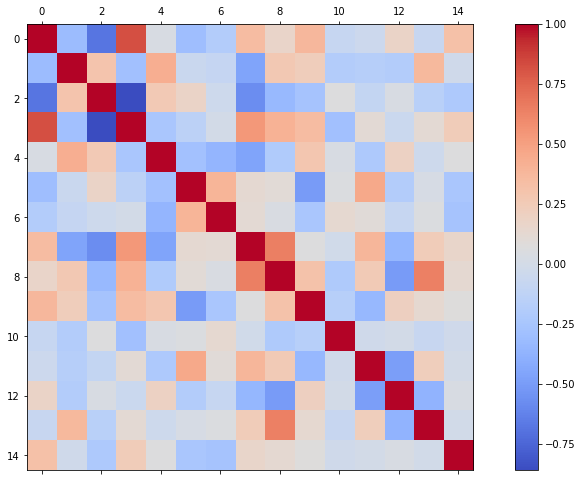

In [30]:
#@title Generar Matriz de Correlación 
# muestra la matriz
print('Matriz de Correlación:\n')
corr = ndf.corr() 
display( corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3) )
print("\n")

# muestra la figura
fig = plt.figure(figsize=(15,8)) 
plt.matshow(corr,  fignum=fig.number, cmap='coolwarm')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
#plt.title('Matriz de Correlación')
plt.show()

#Resultados de aplicar Algoritmos de Minería de Datos:

In [31]:
#@title Aplicar Descubrimiento de Reglas ( Decision Tree ) { run: "auto" }

# carga las columnas no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)

if len(colNoValues)<1:
  raise ValueError("No se encuentra ningún atributo no numérico para utilizar como objetivo!!!")

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atr.Entrada:')

comboClase = widgets.Dropdown(
    options=colNoValues,
    value=(atributo_clase if atributo_clase!="" else colNoValues[0]),
    description='Atr.Clase:',
    disabled=False,
)

ui = widgets.HBox([selColumnas, comboClase])

def cambiaSeleccion(atributos_entrada, atributo_clase_tree):      
    # convierte la selección a un array 
    # agrega el atributo clase para mostrar
    cols = list(atributos_entrada)
    cols.append(atributo_clase_tree)                       
    arCols = np.array(cols)

    # obtiene los datos para entrenar el algoritmo
    X, Y, xColName = separarDatosXY(ndf[arCols], atributo_clase_tree, xSoloNros=True)

    # determina nombre de atributos y valores clase
    cols = xColName
    classvalues = np.unique(Y)

    # genera el árbol y lo muestra
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, Y)

    # muestra el árbol
    plt.figure(figsize=(15,8))   
    tree.plot_tree(clf, 
                  feature_names=cols, 
                  class_names=classvalues, 
                  impurity=False, 
                  rounded=True, 
                  fontsize=11)
    plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'atributos_entrada': selColumnas, 'atributo_clase_tree': comboClase})
display(ui, out)    

Output()

In [32]:
#@title Aplicar Ponderación ( Naive Bayes )

# carga las columnas numéricas y no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)

if len(colNoValues)<1:
  raise ValueError("No se encuentra ningún atributo no numérico para utilizar como objetivo!!!")

# agrega los combos
comboEnt = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Atr.Entrada:',
    disabled=False,
)

comboClase = widgets.Dropdown(
    options=colNoValues,
    value=colNoValues[0],
    description='Atr.Clase:',
    disabled=False,
)

ui = widgets.HBox([comboEnt, comboClase])

def cambiaSeleccion(atributo_valor_naiveBayes, atributo_clase_naiveBayes):
  # genera el gráfico
  plt.figure(figsize=(15,8))
  legValues = []   
  # procesa los valores del atributo clase
  for val in ndf[atributo_clase_naiveBayes].fillna("-NAN-").unique():
      # filtra los datos
      auxDF = ndf[ ndf[atributo_clase_naiveBayes] == val]
      # obtiene valores X, Y de clase y atributo
      Y = np.array(auxDF.pop(atributo_clase_naiveBayes).fillna("-NAN-"))
      X = np.array(auxDF[atributo_valor_naiveBayes].fillna(0.001))   
      if len(X)>0 and len(Y)>0:
        legValues.append(val)
        # calcula la densidad
        # instantiate and fit the KDE model
        kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
        kde.fit(X[:, None])      
        # score_samples returns the log of the probability density
        x_d = np.linspace(np.min(X), np.max(X), 1000)
        logprob = kde.score_samples(x_d[:, None])
        # genera área del atributo
        plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
        plt.plot(X, np.full_like(X, -0.01), '|k', markeredgewidth=1)
  plt.xlabel("Valores")
  plt.ylabel("Frecuencia")
  plt.legend(legValues, loc='best')
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'atributo_valor_naiveBayes': comboEnt, 'atributo_clase_naiveBayes': comboClase })
display(ui, out)


Output()

In [33]:
#@title Aplicar Clustering ( K-Means ) { run: "auto" }

#@markdown Cantidad de clústeres a generar:
cantidad_clusters = 3 #@param {type:"integer"}
#@markdown Nombre del atributo clase / objetivo a descartar en el clustering:
atributo_clase_descartar_clustering = "" #@param {type:"string"}

# como mínimo se tienen que generar dos clusters
if cantidad_clusters < 2:
  cantidad_clusters = 2

# controla que exista el atributo_clase
if atributo_clase_descartar_clustering != "" and atributo_clase_descartar_clustering not in ndf:
  raise ValueError("El atributo '" + atributo_clase_descartar_clustering + "' no existe en los datos cargados!!!")

# obtiene los datos para entrenar el algoritmo
X, Y, colValues = separarDatosXY(ndf, atributo_clase_descartar_clustering, xSoloNros=True)
colValues = list(colValues)

# Entrena K-Means
kmeans = KMeans(n_clusters=cantidad_clusters).fit(X)
centroids = kmeans.cluster_centers_
print("Centroides Generados: \n", centroids)
print("\n")

# Determina la salida
labels = kmeans.predict(X)

# agrega los combos
comboColX = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY])

def cambiaSeleccion(x, y):
  # llama a la función 
  # para generar el gráfico con las columnas seleccionadas
  plt.figure(figsize=(15,8))
  plt.scatter(X[:, colValues.index(x)], X[:, colValues.index(y)], c=labels)
  plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY})
display(ui, out)




Centroides Generados: 
 [[ 8.33333333e-02  2.77555756e-17  7.50000000e-01  1.66666667e-01
  -5.55111512e-17  6.66666667e-01  7.50000000e-01  7.50000000e-01
   7.50000000e-01  4.16666667e-01  3.33333333e-01  5.00000000e-01
   0.00000000e+00  6.66666667e-01  8.33333333e-02]
 [ 3.00000000e-01  2.77555756e-17  9.00000000e-01  5.55111512e-17
   5.00000000e-01  3.00000000e-01  5.00000000e-01  1.11022302e-16
   1.11022302e-16  7.00000000e-01  3.00000000e-01 -2.77555756e-17
   6.30000000e+00  1.00000000e-01  1.00000000e-01]
 [ 4.64285714e-01  2.85714286e-01  5.71428571e-01  4.64285714e-01
   2.14285714e-01  3.92857143e-01  5.71428571e-01  6.07142857e-01
   9.64285714e-01  9.64285714e-01  3.57142857e-02  3.57142857e-02
   3.07142857e+00  7.14285714e-01  1.78571429e-01]]




Output()